We will focus on selecting
the algorithm parameters, known as hyperparameters to distinguish them from the
parameters that are adjusted within the machine learning algorithm.

In [1]:
%pylab inline
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(subset='all')

n_samples = 3000

X = news.data[:n_samples]
y = news.target[:n_samples]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
def get_stop_words():
    result = set()
    for line in open('stopwords_en.txt', 'r').readlines():
        result.add(line.strip())
    return result

stop_words = get_stop_words()

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('nb', MultinomialNB(alpha=0.01)),
])

#### Evaluate our algorithm with a three-fold cross-validation

In [4]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))

In [5]:
evaluate_cross_validation(clf, X, y, 3)

[ 0.812  0.808  0.822]
Mean score: 0.814 (+/-0.004)


It looks like we should train the algorithm with a list of different parameter values
and keep the parameter value that achieves the best results. Let's implement a helper
function to do that. This function will train the algorithm with a list of values, each
time obtaining an accuracy score calculated by performing k-fold cross-validation
on the training instances. After that, it will plot the training and testing scores as a
function of the parameter values.

In [6]:
def calc_params(X, y, clf, param_values, param_name, K):
    # initialize training and testing scores with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        print (param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_samples, K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        for j, (train, test) in enumerate(cv):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.semilogx(param_values, train_scores, alpha=0.4, lw=2, c='b')
    plt.semilogx(param_values, test_scores, alpha=0.4, lw=2, c='g')
    
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

The function accepts six arguments: the feature array, the target array, the classifier
object to be used, the list of parameter values, the name of the parameter to adjust,
and the number of K folds to be used in the crossvalidation evaluation.

we will use numpy's logspace function to generate a list of
alpha values spaced evenly on a log scale.

In [7]:
alphas = np.logspace(-7, 0, 8)
print (alphas)

[  1.00000000e-07   1.00000000e-06   1.00000000e-05   1.00000000e-04
   1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00]


nb__alpha  =  1e-07
nb__alpha  =  1e-06
nb__alpha  =  1e-05
nb__alpha  =  0.0001
nb__alpha  =  0.001
nb__alpha  =  0.01
nb__alpha  =  0.1
nb__alpha  =  1.0


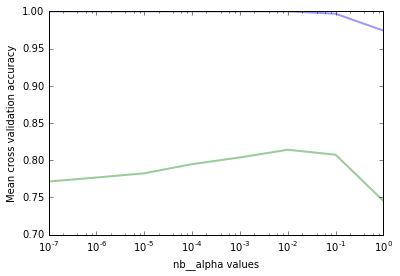

In [8]:
train_scores, test_scores = calc_params(X, y, clf, alphas, 'nb__alpha', 3)

the training accuracy is always greater than the testing accuracy. We
can see in the graph that the best testing accuracy is obtained with an alpha value in
the range of 10-2 and 10-1. Below this range, the classifier shows signs of overfitting
(the training accuracy is high but the testing accuracy is lower than it could be).
Above this range, the classifier shows signs of underfitting (accuracy on the training
set is lower than it could be).

It is worth mentioning that at this point a second pass could be performed in the
range of 10-2 and 10-1with a finer grid to find an ever better alpha value.

In [9]:
print ('training scores: ', train_scores)
print ('testing scores: ', test_scores)

training scores:  [ 1.          1.          1.          1.          1.          1.
  0.99683333  0.97416667]
testing scores:  [ 0.77133333  0.77666667  0.78233333  0.79466667  0.80366667  0.814
  0.80733333  0.74533333]


The best results are obtained with an alpha value of 1.0 or 0.1 (accuracy of 0.814 or 0.807).

#### Let us try on SVM

In [10]:
from sklearn.svm import SVC

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

svc__gamma  =  0.01
svc__gamma  =  0.1
svc__gamma  =  1.0
svc__gamma  =  10.0


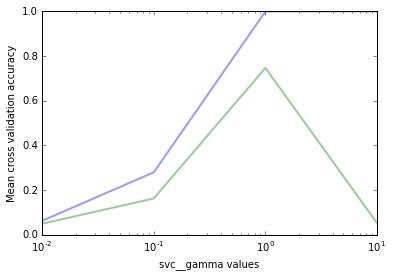

In [11]:
gammas = np.logspace(-2, 1, 4)

train_scores, test_scores = calc_params(X, y, clf, gammas, 'svc__gamma', 3)

For gamma values lesser than one we have underfitting and for gamma values
greater than one we have overfitting.

In [12]:
print ('training scores: ', train_scores)
print ('testing scores: ', test_scores)

training scores:  [ 0.06183333  0.279       0.99966667  1.        ]
testing scores:  [ 0.04866667  0.162       0.74666667  0.05166667]


So the best result is for a gamma value of 1, where we obtain a training accuracy of
0.999 and a testing accuracy of 0.760.

To mitigate the problem of trying all the parameter combinations, sklearn has got GridSearchCV within
the sklearn.grid_search module. What we have been doing with our calc_
params function is a kind of grid search in one dimension. With GridSearchCV, we
can specify a grid of any number of parameters and parameter values to traverse. It
will train the classifier for each combination and obtain a cross-validation accuracy to
evaluate each one.

Let's use it to adjust the C and the gamma parameters in SVM at the same time.

In [20]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'svc__gamma': np.logspace(-2, 1, 4),
    'svc__C': np.logspace(-1, 1, 3),
}

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

gs = GridSearchCV(clf, parameters, verbose=2, refit=False, cv=3)

Let's execute our grid search and print the best parameter values and scores.

In [21]:
%time _ = gs.fit(X, y)

gs.best_params_, gs.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] svc__C=0.1, svc__gamma=0.01 .....................................
[CV] ............................ svc__C=0.1, svc__gamma=0.01 -   8.4s
[CV] svc__C=0.1, svc__gamma=0.01 .....................................
[CV] ............................ svc__C=0.1, svc__gamma=0.01 -   8.9s
[CV] svc__C=0.1, svc__gamma=0.01 .....................................
[CV] ............................ svc__C=0.1, svc__gamma=0.01 -   9.3s
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] ............................. svc__C=0.1, svc__gamma=0.1 -  10.5s
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] ............................. svc__C=0.1, svc__gamma=0.1 -   9.2s
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] ............................. svc__C=0.1, svc__gamma=0.1 -   9.8s
[CV] svc__C=0.1, svc__gamma=1.0 ......................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.5min finished


({'svc__C': 10.0, 'svc__gamma': 0.10000000000000001}, 0.82666666666666666)

With the grid search, we obtained a better combination of C and gamma parameters,
for values 10.0 and 0.10 respectively, with a three-fold cross-validation accuracy of
0.811, which is much better than the best value we obtained (0.76) in the previous
experiment by only adjusting gamma and keeping the C value at 1.0.

### Parallel grid search

Grid search calculation grows exponentially with each parameter and its possible
values we want to tune. We could reduce our response time if we calculate each
of the combinations in parallel instead of sequentially, as we have done. In our
previous example, we had four different values for gamma and three different values
for C, summing up 12 parameter combinations. Additionally, we also needed to train
each combination three times (in a three-fold cross-validation), so we summed up
36 trainings and evaluations.

First we will declare a function that will persist all the K folds for the cross validation in different files. These files will be loaded by a process that will execute the corresponding fold:

In [22]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits(X, y, K=3, name='data', suffix="_cv_%03d.pkl"):
    """Dump K folds to filesystem."""
    
    cv_split_filenames = []
    
    # create KFold cross validation
    cv = KFold(n_samples, K, shuffle=True, random_state=0)
    
    # iterate over the K folds
    for i, (train, test) in enumerate(cv):
        cv_fold = ([X[k] for k in train], y[train], [X[k] for k in test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

In [23]:
cv_filenames = persist_cv_splits(X, y, name='news')

The following function loads a particular fold and fits the classifier with the specified
parameter set, returning the testing score. This function will be called by each of the
parallel tasks.

In [24]:
def compute_evaluation(cv_split_filename, clf, params):
    
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    # load the fold training and testing partitions from the filesystem
    X_train, y_train, X_test, y_test = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return test_score

Finally, the following function executes the grid search in parallel tasks. For each
parameter combination (returned by the IterGrid iterator), it iterates over K folds
and creates a task to compute the evaluation. It returns the parameter combinations
alongside the tasks list.

In [25]:
from sklearn.grid_search import ParameterGrid

def parallel_grid_search(lb_view, clf, cv_split_filenames, param_grid):
    
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    # iterate over parameter combinations
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        # iterate over the K folds
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, clf, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

Now we use IPython parallel to get the client and a load balanced view. We must first create a local cluster of N engines by using the Cluster tab in the IPython notebook. Then we create the client, the view and execute our parallel_grid_search function:

In [26]:
from sklearn.svm import SVC
import ipyparallel as ipp
import os

client = ipp.Client()
lb_view = client.load_balanced_view()

all_parameters, all_tasks = parallel_grid_search(
   lb_view, clf, cv_filenames, parameters)

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


OSError: Connection file '~\\.ipython\\profile_default\\security\\ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [ ]:
def print_progress(tasks):
    progress = np.mean([task.ready() for task_group in tasks
                                 for task in task_group])
    print ("Tasks completed: {0}%".format(100 * progress))

In [ ]:
print_progress(all_tasks)

In [ ]:
def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

In [ ]:
print find_bests(all_parameters, all_tasks)

You can observe that we computed the same results as in the previous section,
but in half the time (if you used two cores) or in a quarter of the time (if you used
four cores).